# Accessing data
- __ERA5__:
    - ECMWF Reanalysis product, global product ~1960 onwards
    - project: rt52
    - directory: /g/data/rt52/era5/single-levels/reanalysis/
    - size: ~12GB for 2020, x37 levels for multiple level datasets
    - resolution: 0.25 degree resolution in netcdf files
    - 774 netcdf month files per variable
- BARRA:






In [1]:
## Imports
import xarray as xr
import numpy as np
import pandas as pd

import time
from glob import glob
import importlib
import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Put us in the right repo for local relative pathing
import os
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric/"
os.chdir(__repo__)

import fio,plotting

In [2]:
## This one requires :
#  conda activate analysis3
#  python3 -m pip install --user regionmask
import regionmask

In [2]:
## Dask
from dask.distributed import Client
client = Client()
print(client.dashboard_link)

/proxy/8787/status


In [4]:
importlib.reload(fio)

<module 'fio' from '/g/data/en0/jwg574/repos/climate_fire/fio.py'>

In [5]:
%%time
ds = fio.ERA5_read_month(['u10','v10','u10n','v10n','d2m','t2m'],'2019-12')

CPU times: user 43.5 ms, sys: 7.75 ms, total: 51.3 ms
Wall time: 52.2 ms


In [12]:

importlib.reload(fio)

<module 'fio' from '/g/data/en0/jwg574/repos/climate_fire/fio.py'>

In [6]:
## add 10m wind magnitude
ds = fio.calc_s10(ds)
## add RH at 10m
ds = fio.calc_rh(ds)
## add FFDI mark 5
ds = fio.calc_ffdi(ds)

In [14]:
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 321, time: 744)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... -59.5 -59.75 -60.0
  * time       (time) datetime64[ns] 2019-12-01 ... 2019-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    u10n       (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    v10n       (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    s10        (time, latitude

In [9]:
importlib.reload(plotting)

<module 'plotting' from '/g/data/en0/jwg574/repos/climate_fire/plotting.py'>

## Check out sample of FFDI and driving variables

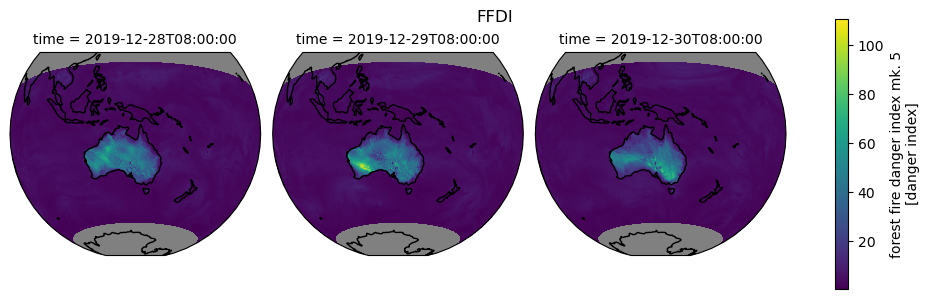

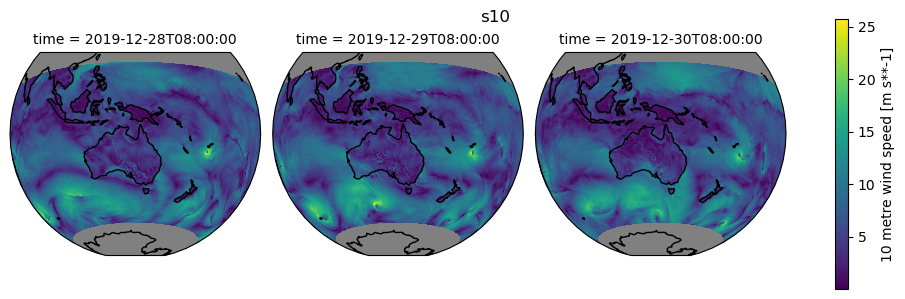

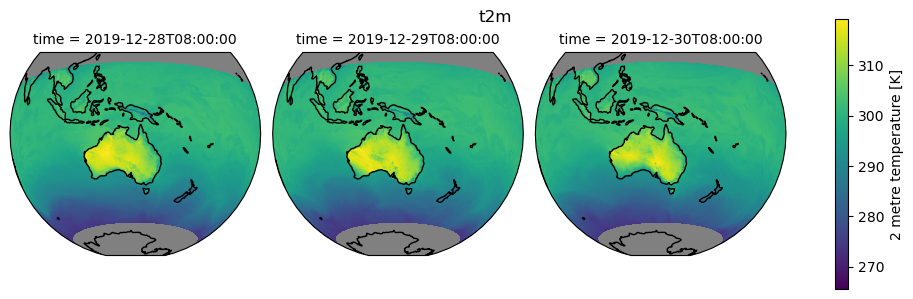

CPU times: user 13 s, sys: 1.68 s, total: 14.7 s
Wall time: 12.1 s


In [16]:
%%time

# ~ 24 seconds for 5 variables, 4 times
for var in ['FFDI','s10','t2m']:#,'d2m','rh2m']:
    plotting.plot_quick(ds[var],itimes=[656,680,704])
    plt.suptitle(var);
    plt.show()
    


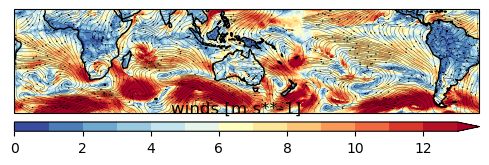

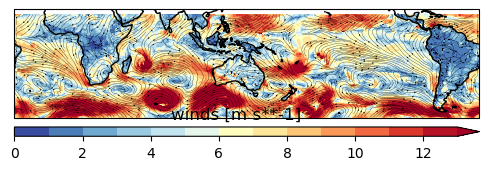

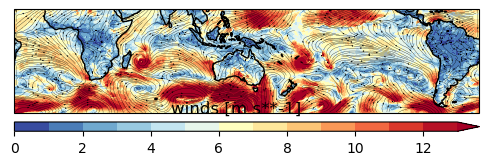

In [17]:
importlib.reload(plotting)

plotting.plot_winds(ds,itimes=[656,680,704])

# Region Masking

In [25]:
import regionmask

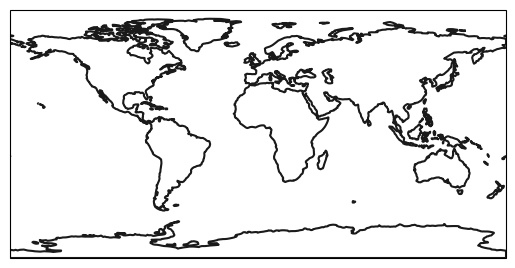

In [17]:

regionmask.defined_regions.natural_earth_v5_0_0.land_110.plot(add_label=False);
plt.show()


In [28]:
importlib.reload(fio)

<module 'fio' from '/g/data/en0/jwg574/repos/climate_fire/fio.py'>

In [29]:
## First subset to AU area
ds = fio.select_australia(ds)

print(ds.FFDI.shape)
ausmask = fio.get_landmask(ds.FFDI)
print(ausmask.shape)


(744, 157, 177)
(157, 177)


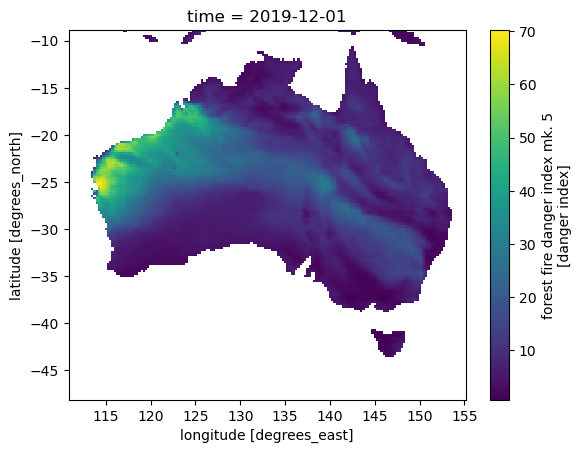

In [30]:
ds.FFDI.where(ausmask).isel(time=0).plot()

# Read all time

For looking at percentiles, etc...

In [25]:
from fio import ERA5_read_long

In [26]:
fname = '/scratch/en0/jwg574/ERA5/Aus_FFDI.nc'
if os.path.isfile(fname)
    #omg_large_ds=ERA5_read_long( ['u10','v10','d2m','t2m'])
    ## Save ERA5_Aus?
    #omg_large_ds.to_netcdf(fname)
    # latrange=[-48,-9]
    # lonrange=[111,155]
    # ## subset just AUS:
    # omg_large_ds = omg_large_ds.sel(latitude=slice(max(latrange),min(latrange)))
    # omg_large_ds = omg_large_ds.sel(longitude=slice(min(lonrange),max(lonrange)))
    # omg_large_ds
    omg_large_ds = xr.load_datasets(fname,chunks={'time':2000,'latitude':40,'longitude':40})
    omg_large_ds

INFO: reading 825 files for u10
INFO: reading 825 files for v10
INFO: reading 825 files for d2m
INFO: reading 825 files for t2m
CPU times: user 34.9 s, sys: 8.61 s, total: 43.5 s
Wall time: 1min 44s


In [24]:
importlib.reload(fio)

<module 'fio' from '/g/data/en0/jwg574/repos/climate_fire/fio.py'>

In [6]:
%%time
## Calculate FFDI possible?
omg_large_ds = fio.calc_ffdi(omg_large_ds)

CPU times: user 92.7 ms, sys: 0 ns, total: 92.7 ms
Wall time: 89.8 ms


In [7]:
%%time
# yearly is around 120 MB
# year starts jan1
FFDI_yearly_max = omg_large_ds.FFDI.resample(time='AS').max('time')


CPU times: user 10.1 s, sys: 343 ms, total: 10.4 s
Wall time: 10.4 s


In [8]:
print(FFDI_yearly_max.shape)


(69, 157, 177)


In [9]:
dir_yearlymax='ERA5/ffdi_yearlymax'
if not os.path.isdir(dir_yearlymax):
    os.makedirs(dir_yearlymax)

In [14]:
%%time

FFDI_monthly_max = xr.open_dataarray(fname)

CPU times: user 29 ms, sys: 33.9 ms, total: 62.9 ms
Wall time: 152 ms


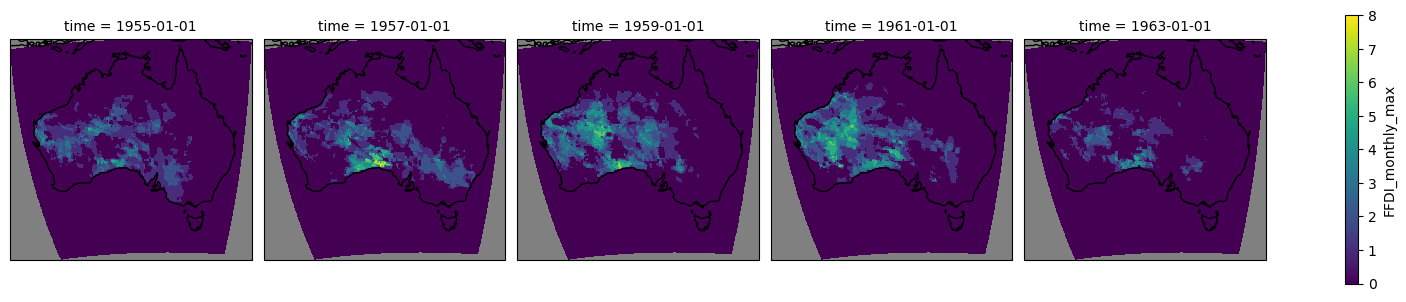

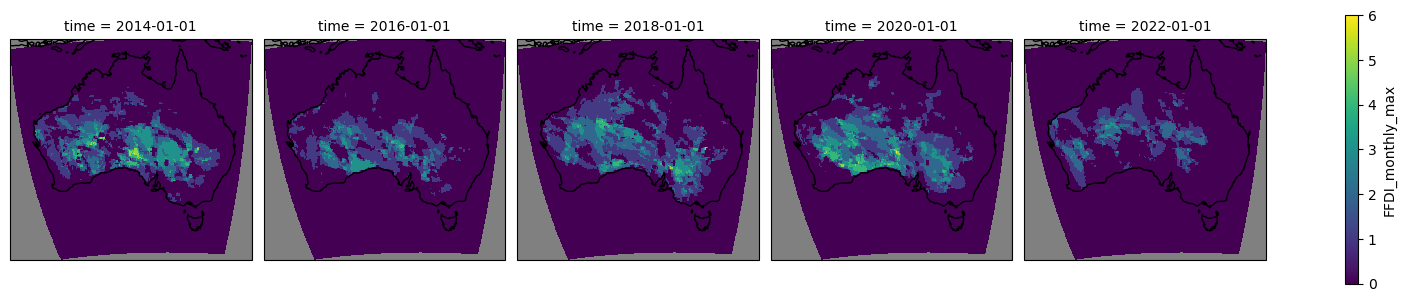

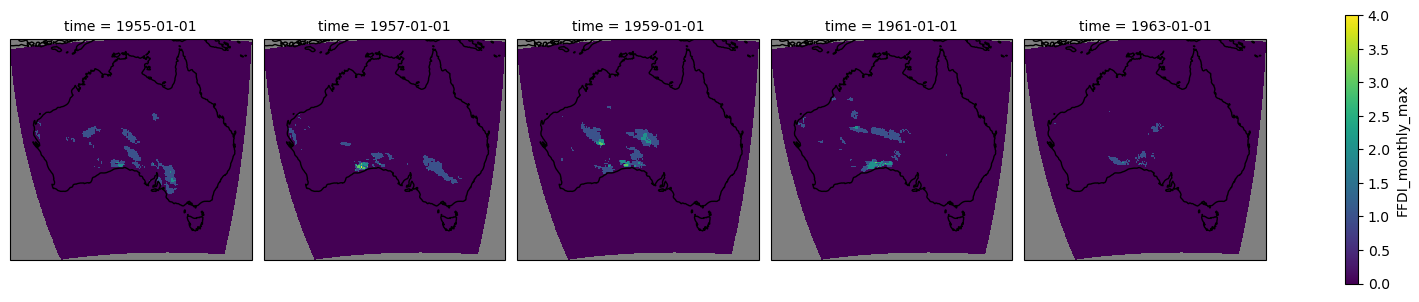

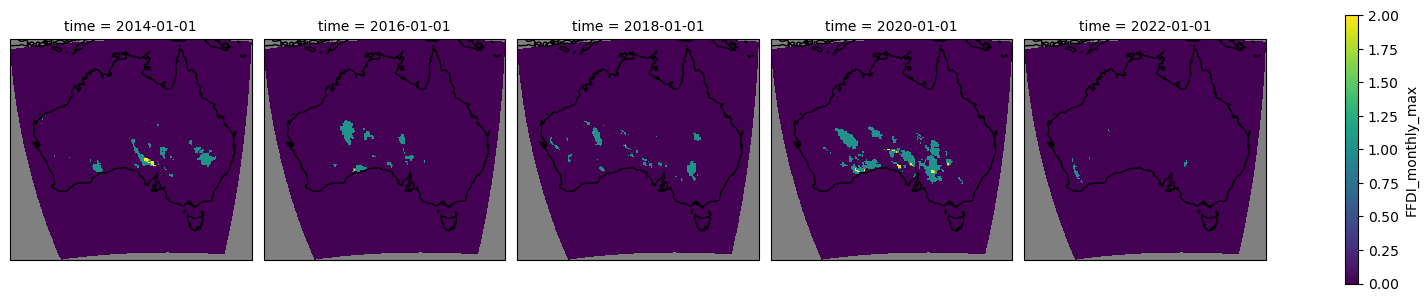

In [18]:

monthly_over_75 = FFDI_monthly_max > 75
monthly_over_100 = FFDI_monthly_max > 100

months_over_75 = monthly_over_75.resample(time='AS').sum(dim='time')
months_over_100 = monthly_over_100.resample(time='AS').sum(dim='time')



In [10]:
%%time
importlib.reload(plotting)

years = FFDI_yearly_max['time.year'].values
n_years=len(FFDI_yearly_max['time'])


## plot out images to scratch
for i,year in enumerate(years):
    
    plotting.plot_ffdi(FFDI_yearly_max,itimes=[i],lat0=-15)
    figname = '%s/%d.png'%(dir_yearlymax,year)
    plt.savefig(figname)
    plt.close()
    print("INFO: saved figure %s"%figname, end='\r')

CPU times: user 19min 45s, sys: 1min 32s, total: 21min 18s
Wall time: 1h 47min 59s


## What is difference between u10 and u10n (interp assuming neutral stability)?

In [16]:
importlib.reload(plotting)

<module 'plotting' from '/g/data/en0/jwg574/repos/climate_fire/plotting.py'>

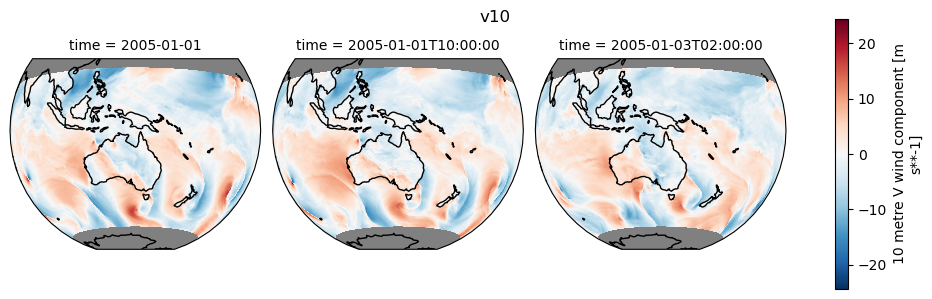

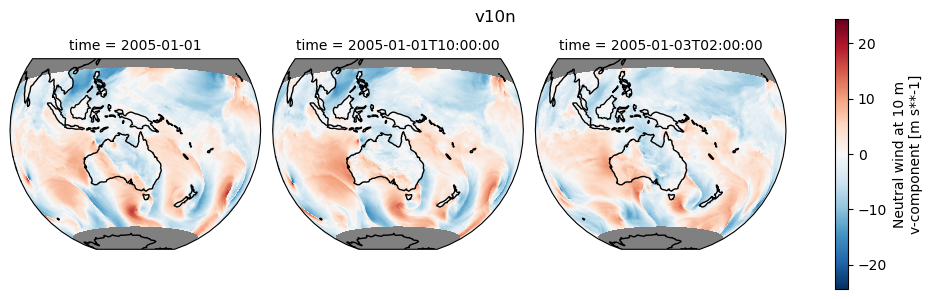

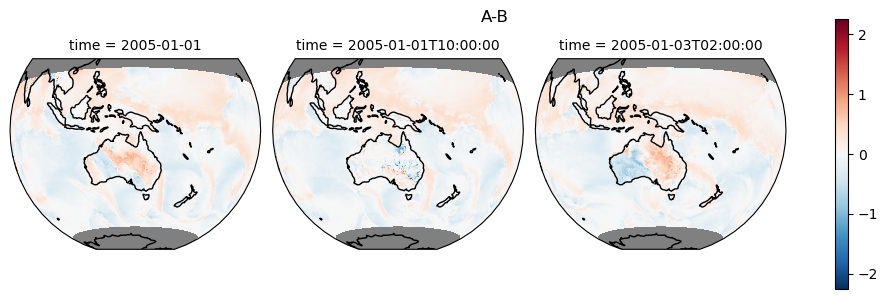

In [72]:
plotting.plot_diff_quick(ds.v10,ds.v10n,itimes=[0,10,50])

# BARRA? CMIP6?

# ENSO 3.4
https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt

In [40]:
import pandas as pd
importlib.reload(fio)

<module 'fio' from '/g/data/en0/jwg574/repos/climate_fire/fio.py'>

In [43]:
from fio import read_enso_rolling3m


In [44]:
oni=read_enso_rolling3m()

In [56]:
oni.index.values[0]

numpy.datetime64('1950-01-01T00:00:00.000000000')

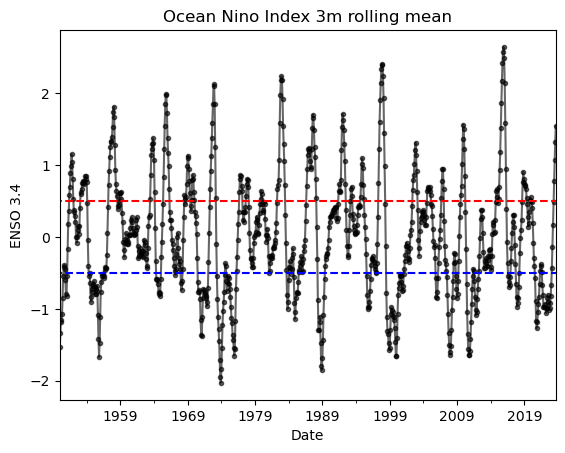

In [70]:
oni.ANOM.plot(c='k',marker='.',alpha=0.6)
plt.plot([oni.index.values[0],oni.index.values[-1]],[-.5,-.5],'b--')
plt.plot([oni.index.values[0],oni.index.values[-1]],[.5,.5],'r--')
plt.ylabel('ENSO 3.4')
plt.title('Ocean Nino Index 3m rolling mean');
